#### Visualization of Xenium add-on panel healthy gut data after the labels transer 
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 20th March 2024

##### Import packages

In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
from scipy.sparse import coo_matrix

#### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.1.0
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          3.3.2
cloudpickle                 3.0.0
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
dask                        2024.1.1
dask_image                  2023.08.1
datashader                  0.16.0
datatree                    0.0.13
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
docrep                   

#### Data upload

+ Load h5ad object

In [3]:
adata_xenium = sc.read_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/10X_Xenium_add-on_with_image.h5ad')

#### Visualise predicted cell types - after cell types + Stem cells labels transfer

+ Upload the object with cell types

In [4]:
adata_full = sc.read_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/Xenium_add_on_data_scANVI_cell_type_and_stem_cells.h5ad')

In [11]:
adata_full.obs.index.name = 'cell_id'

In [14]:
adata_xenium.obs.index.name = 'cell_id'

In [16]:
adata_xenium.obs = adata_xenium.obs.merge(adata_full.obs[['C_scANVI']], on='cell_id', how='left')

In [17]:
adata_xenium.obs.rename(columns={'C_scANVI':'Cell_Type'}, inplace=True)

+ Visualise only image

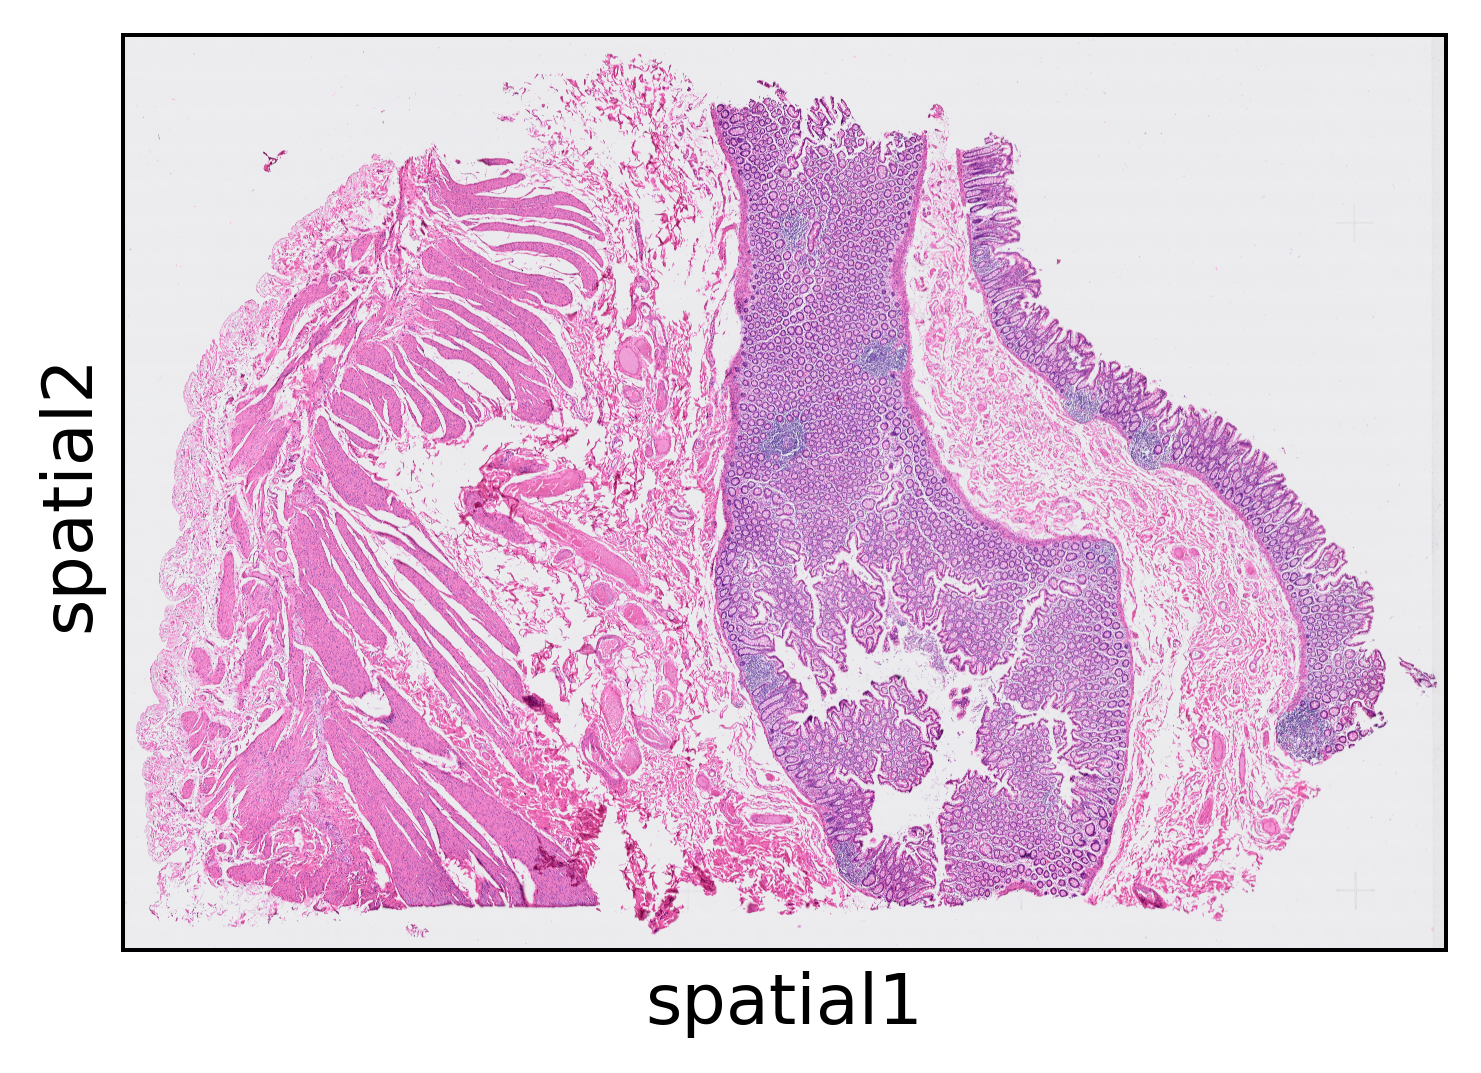

In [7]:
sq.pl.spatial_scatter(adata_xenium)

In [18]:
adata_xenium.obs['Cell_Type'].value_counts()

Cell_Type
Epithelial      93101
Mesenchymal     80455
Myeloid         25042
Plasma cells    20556
Endothelial     15379
T cells         14950
B cells         11931
Neuronal         7413
Stem cells       6995
Name: count, dtype: int64

+ Visualize the cell types with standard color pallet

In [ ]:
sc.set_figure_params(scanpy=True, dpi=300, figsize=(10, 10))
sq.pl.spatial_scatter(
    adata_xenium,
    library_id="spatial",
    img=True, img_res_key='lowres',
    shape=None,
    color=[
        "Cell_Type",
    ],
    size=0.1,
    alpha=1
)

In [12]:
adata_xenium.uns['Cell_Type_colors']

['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#17becf']

+ Change the color pallet to highlight stem cells

In [ ]:
# Define your custom color palette
custom_colors = [
    "#41729F",  # B cells
    "#A16AE8",  # Endothelial
    "#B6E5D8",  # Epithelial
    "#EC9EC0",  # Mesenchymal + 
    "#FBE5C8",  # Myeloid + 
    "#4D5D53",  # Neuronal + 
    "#870052",  # Plasma cells + 
    "#FF0000FF",  # Stem cells + 
    "#ffde17"   # T cells +
]

# Update the color codes in the AnnData object
adata_xenium.uns['Cell_Type_colors'] = custom_colors

# Now, when you plot using sq.pl.spatial_scatter, it should use your updated custom colors
sq.pl.spatial_scatter(
    adata_xenium,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color="Cell_Type",
    size=0.1,
    alpha=1
)

+ Visualise only Stem cells

In [51]:
sc.set_figure_params(scanpy=True, dpi=300, figsize=(20, 10))

stem_cells_mask = adata_xenium.obs['C_scANVI_x'] == 'Stem cells'

adata_stem_cells = adata_xenium[stem_cells_mask, :]

In [ ]:
sq.pl.spatial_scatter(
    adata_stem_cells,  # Use the filtered AnnData object.
    library_id="spatial",
    img=True, img_res_key='hires',
    shape=None,  # Assuming you want the default shape.
    color="C_scANVI_x",  # This will now only show 'Stem cells'.
    size=0.1,
    alpha=1
)

+ Add stem cells types

In [19]:
adata_stem_cells = sc.read_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/Stem_cells_scRNA_and_Xenium_add_on_scANVI_7K_cells.h5ad')

In [20]:
adata_stem_cells = adata_stem_cells[adata_stem_cells.obs['Study_name'] == '10X_Xenium_gut_data']

In [21]:
adata_xenium.obs['Stem_cells'] = 'Unknown'
adata_xenium.obs.loc[adata_stem_cells.obs.index, 'Stem_cells'] = adata_stem_cells.obs['C_scANVI']

In [22]:
adata_xenium.obs['Stem_cells'].value_counts()

Stem_cells
Unknown               268827
MTRNR2L12+ASS1+_SC      4855
RPS10+_RPS17+_SC        2025
FXYD3+_CKB+_SC           115
Name: count, dtype: int64

In [23]:
adata_xenium.obs['CellType2'] = adata_xenium.obs['Cell_Type'].copy()
adata_xenium.obs['CellType2'] = adata_xenium.obs['CellType2'].cat.add_categories(['MTRNR2L12+ASS1+_SC',
                                                                                  'RPS10+_RPS17+_SC',
                                                                                  'FXYD3+_CKB+_SC'])

adata_xenium.obs.loc[(adata_xenium.obs['Stem_cells'] == 'MTRNR2L12+ASS1+_SC'), 'CellType2'] = 'MTRNR2L12+ASS1+_SC'
adata_xenium.obs.loc[(adata_xenium.obs['Stem_cells'] == 'RPS10+_RPS17+_SC'), 'CellType2'] = 'RPS10+_RPS17+_SC'
adata_xenium.obs.loc[(adata_xenium.obs['Stem_cells'] == 'FXYD3+_CKB+_SC'), 'CellType2'] = 'FXYD3+_CKB+_SC'

In [24]:
adata_xenium.obs['CellType2'] = adata_xenium.obs['CellType2'].cat.remove_unused_categories()

In [25]:
adata_xenium.obs['CellType2'].value_counts()

CellType2
Epithelial            93101
Mesenchymal           80455
Myeloid               25042
Plasma cells          20556
Endothelial           15379
T cells               14950
B cells               11931
Neuronal               7413
MTRNR2L12+ASS1+_SC     4855
RPS10+_RPS17+_SC       2025
FXYD3+_CKB+_SC          115
Name: count, dtype: int64

+ Visualize cell types + stem cells populations with the standard color pallet

In [ ]:
sc.set_figure_params(scanpy=True, dpi=300, figsize=(10, 10))
sq.pl.spatial_scatter(
    adata_xenium,
    library_id="spatial",
    img=True, img_res_key='lowres',
    shape=None,
    color=[
        "CellType2",
    ],
    size=0.1,
    alpha=1
)

In [29]:
adata_xenium

AnnData object with n_obs × n_vars = 275822 × 425
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'Cell_Type', 'Stem_cells', 'CellType2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'CellType2_colors', 'Cell_Type_colors'
    obsm: 'spatial'

+ Change color pallete

In [ ]:
# Define your custom color palette
custom_colors = [
    "#41729F",  # B cells
    "#A16AE8",  # Endothelial
    "#B6E5D8",  # Epithelial
    "#EC9EC0",  # Mesenchymal + 
    "#FBE5C8",  # Myeloid + 
    "#4D5D53",  # Neuronal + 
    "#870052",  # Plasma cells +  
    "#ffde17",   # T cells +
    "#00B1B0",  # Stem cells MTRN
    "#508FF7",  # Stem cells RPS
    "#FF0000FF"  # Stem cells FXYD
]

# Update the color codes in the AnnData object
adata_xenium.uns['CellType2_colors'] = custom_colors

# Now, when you plot using sq.pl.spatial_scatter, it should use your updated custom colors
sq.pl.spatial_scatter(
    adata_xenium,
    library_id="spatial",
    img=True,
    img_res_key='lowres',
    shape=None,
    color="CellType2",
    size=0.1,
    alpha=1
)

In [26]:
adata_xenium.obs

,imagecol,imagerow,Cell_Type,Stem_cells,CellType2
cell_id,,,,,
aaaagkoa-1,3320.588867,3346.253662,Mesenchymal,Unknown,Mesenchymal
aaablbol-1,2941.872070,3417.557129,Mesenchymal,Unknown,Mesenchymal
aaabogma-1,3389.693848,3386.532959,Mesenchymal,Unknown,Mesenchymal
aaabpdim-1,6174.784180,16895.193359,Mesenchymal,Unknown,Mesenchymal
aaabpfoj-1,6204.396484,16880.251953,Mesenchymal,Unknown,Mesenchymal
...,...,...,...,...,...
oikabfkp-1,33136.144531,12246.299805,Epithelial,Unknown,Epithelial
oikalpjm-1,33070.058594,12269.489258,Epithelial,Unknown,Epithelial
oikamhom-1,33041.335938,12274.116211,Epithelial,Unknown,Epithelial


In [27]:
adata_xenium.write_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/Xenium_add_on_celltypes_and_stem_cells_types.h5ad')

+ Visualise only Stem cells

In [68]:
custom_colors = [
    "#41729F",  # B cells
    "#A16AE8",  # Endothelial
    "#B6E5D8",  # Epithelial
    "#EC9EC0",  # Mesenchymal + 
    "#FBE5C8",  # Myeloid + 
    "#4D5D53",  # Neuronal + 
    "#870052",  # Plasma cells +  
    "#ffde17",   # T cells +
    "#00B1B0",  # Stem cells MTRN
    '#FFDB15',  # Stem cells RPS
    "#FF0000FF"  # Stem cells FXYD
]

# Update the color codes in the AnnData object
adata_xenium.uns['CellType2_colors'] = custom_colors

In [69]:
sc.set_figure_params(scanpy=True, dpi=300, figsize=(20, 10))

cell_types_of_interest = ['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC']

stem_cells_mask = adata_xenium.obs['CellType2'].isin(cell_types_of_interest)

In [70]:
adata_stem_cells = adata_xenium[stem_cells_mask, :]

In [ ]:
sq.pl.spatial_scatter(
    adata_stem_cells,  # Use the filtered AnnData object.
    library_id="spatial",
    img=True, img_res_key='hires',
    shape=None,  # Assuming you want the default shape.
    color="CellType2",  # This will now only show 'Stem cells'.
    size=0.1,
    alpha=1
)